# Introduction
The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store. It has information like the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables.<br>

In this project, I will explore the database and answer the questions below:
- Which three new albums should the store purchase?
- How do the sales agents perform?
- How are sales in difference countries?
- Should Chinook store change its purchasing strategy?

Here's a schema diagram for the Chinook database:

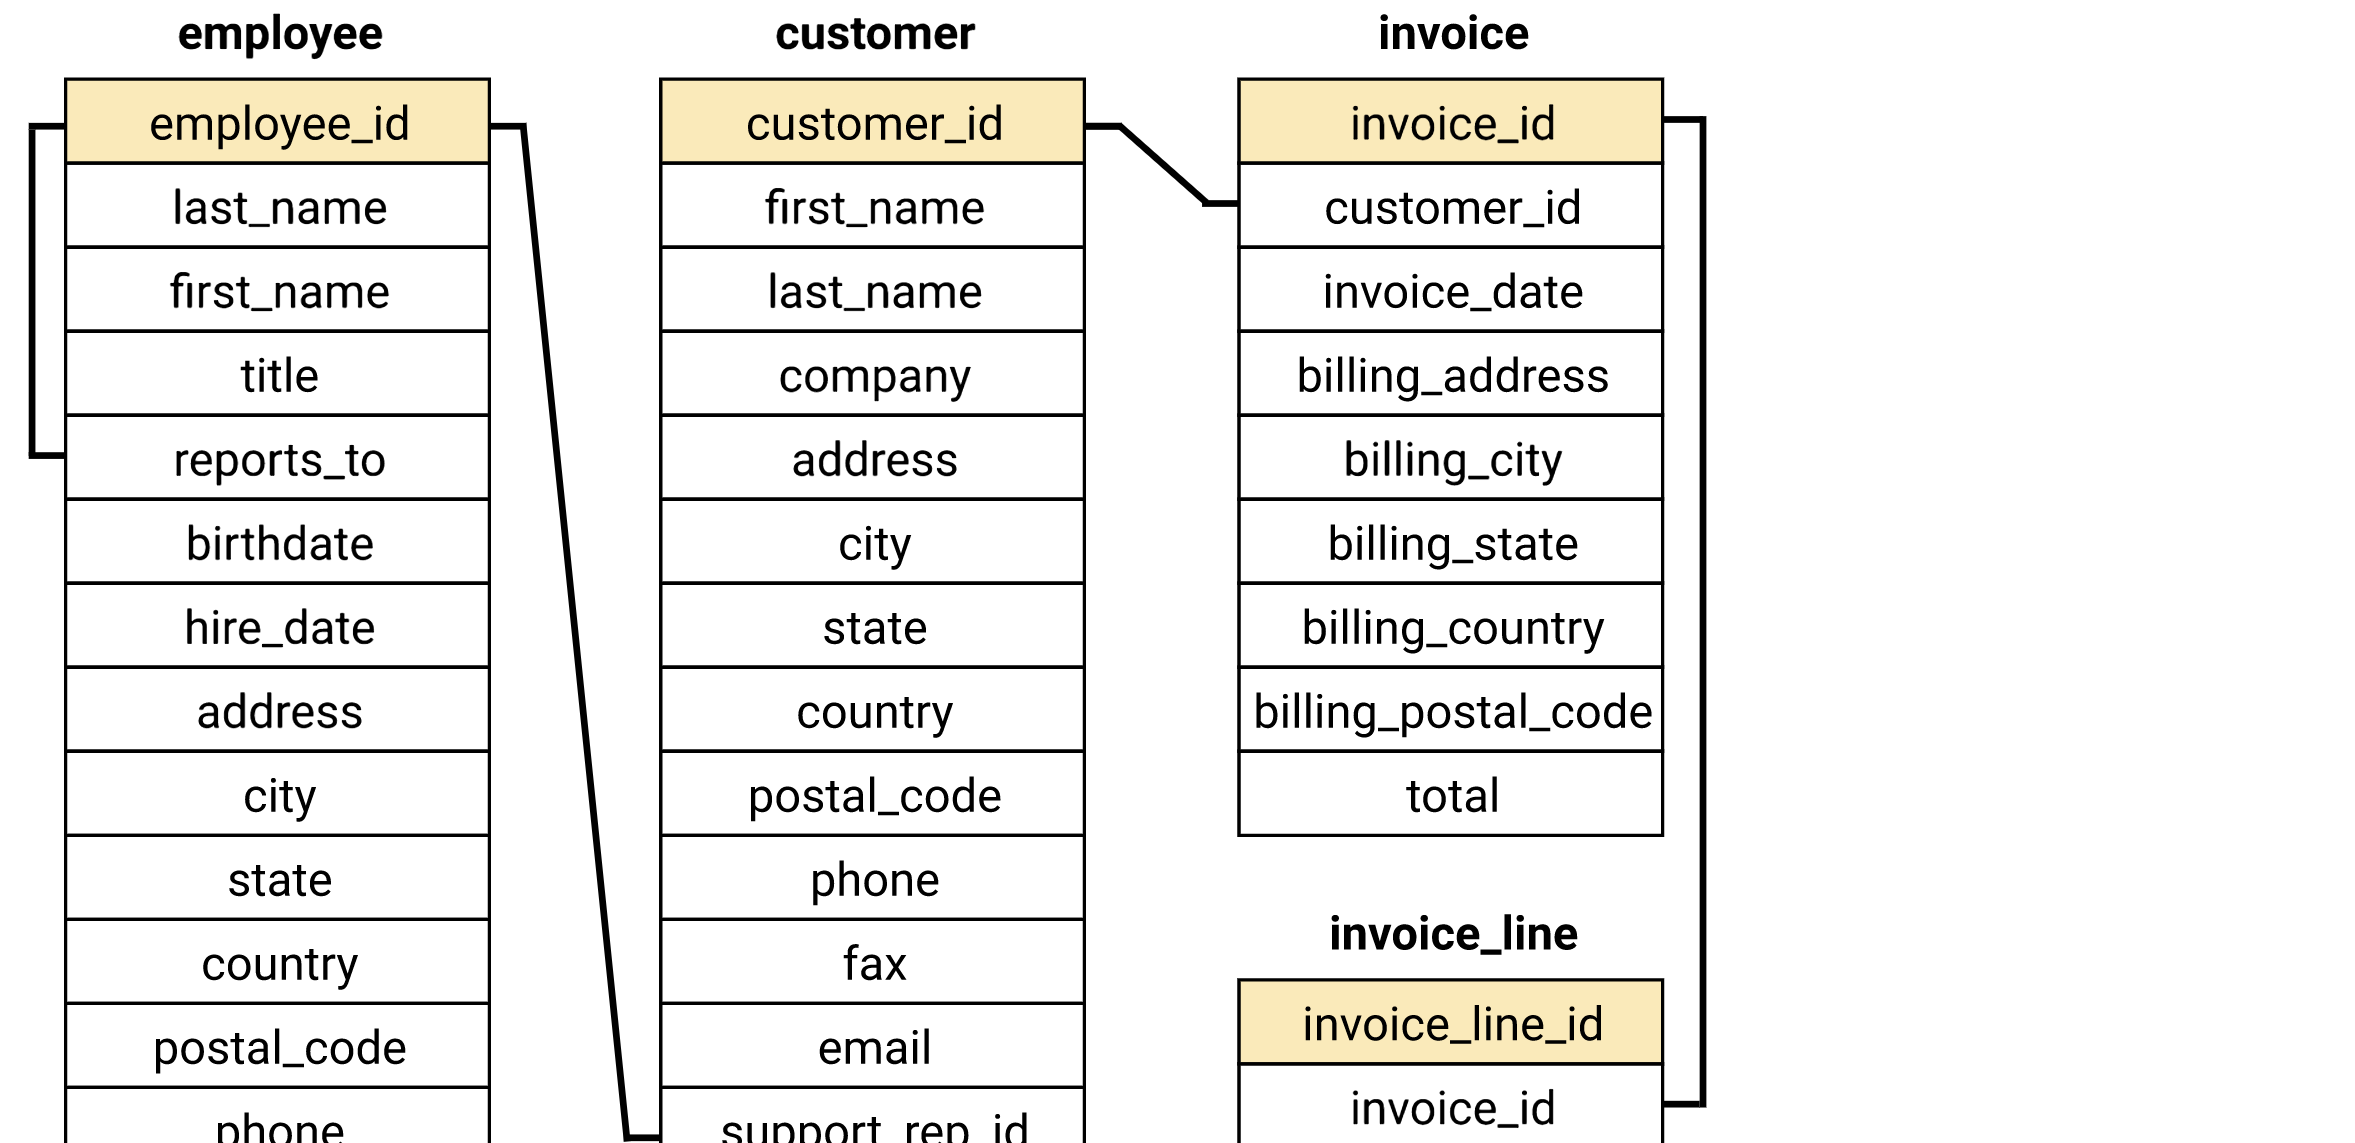

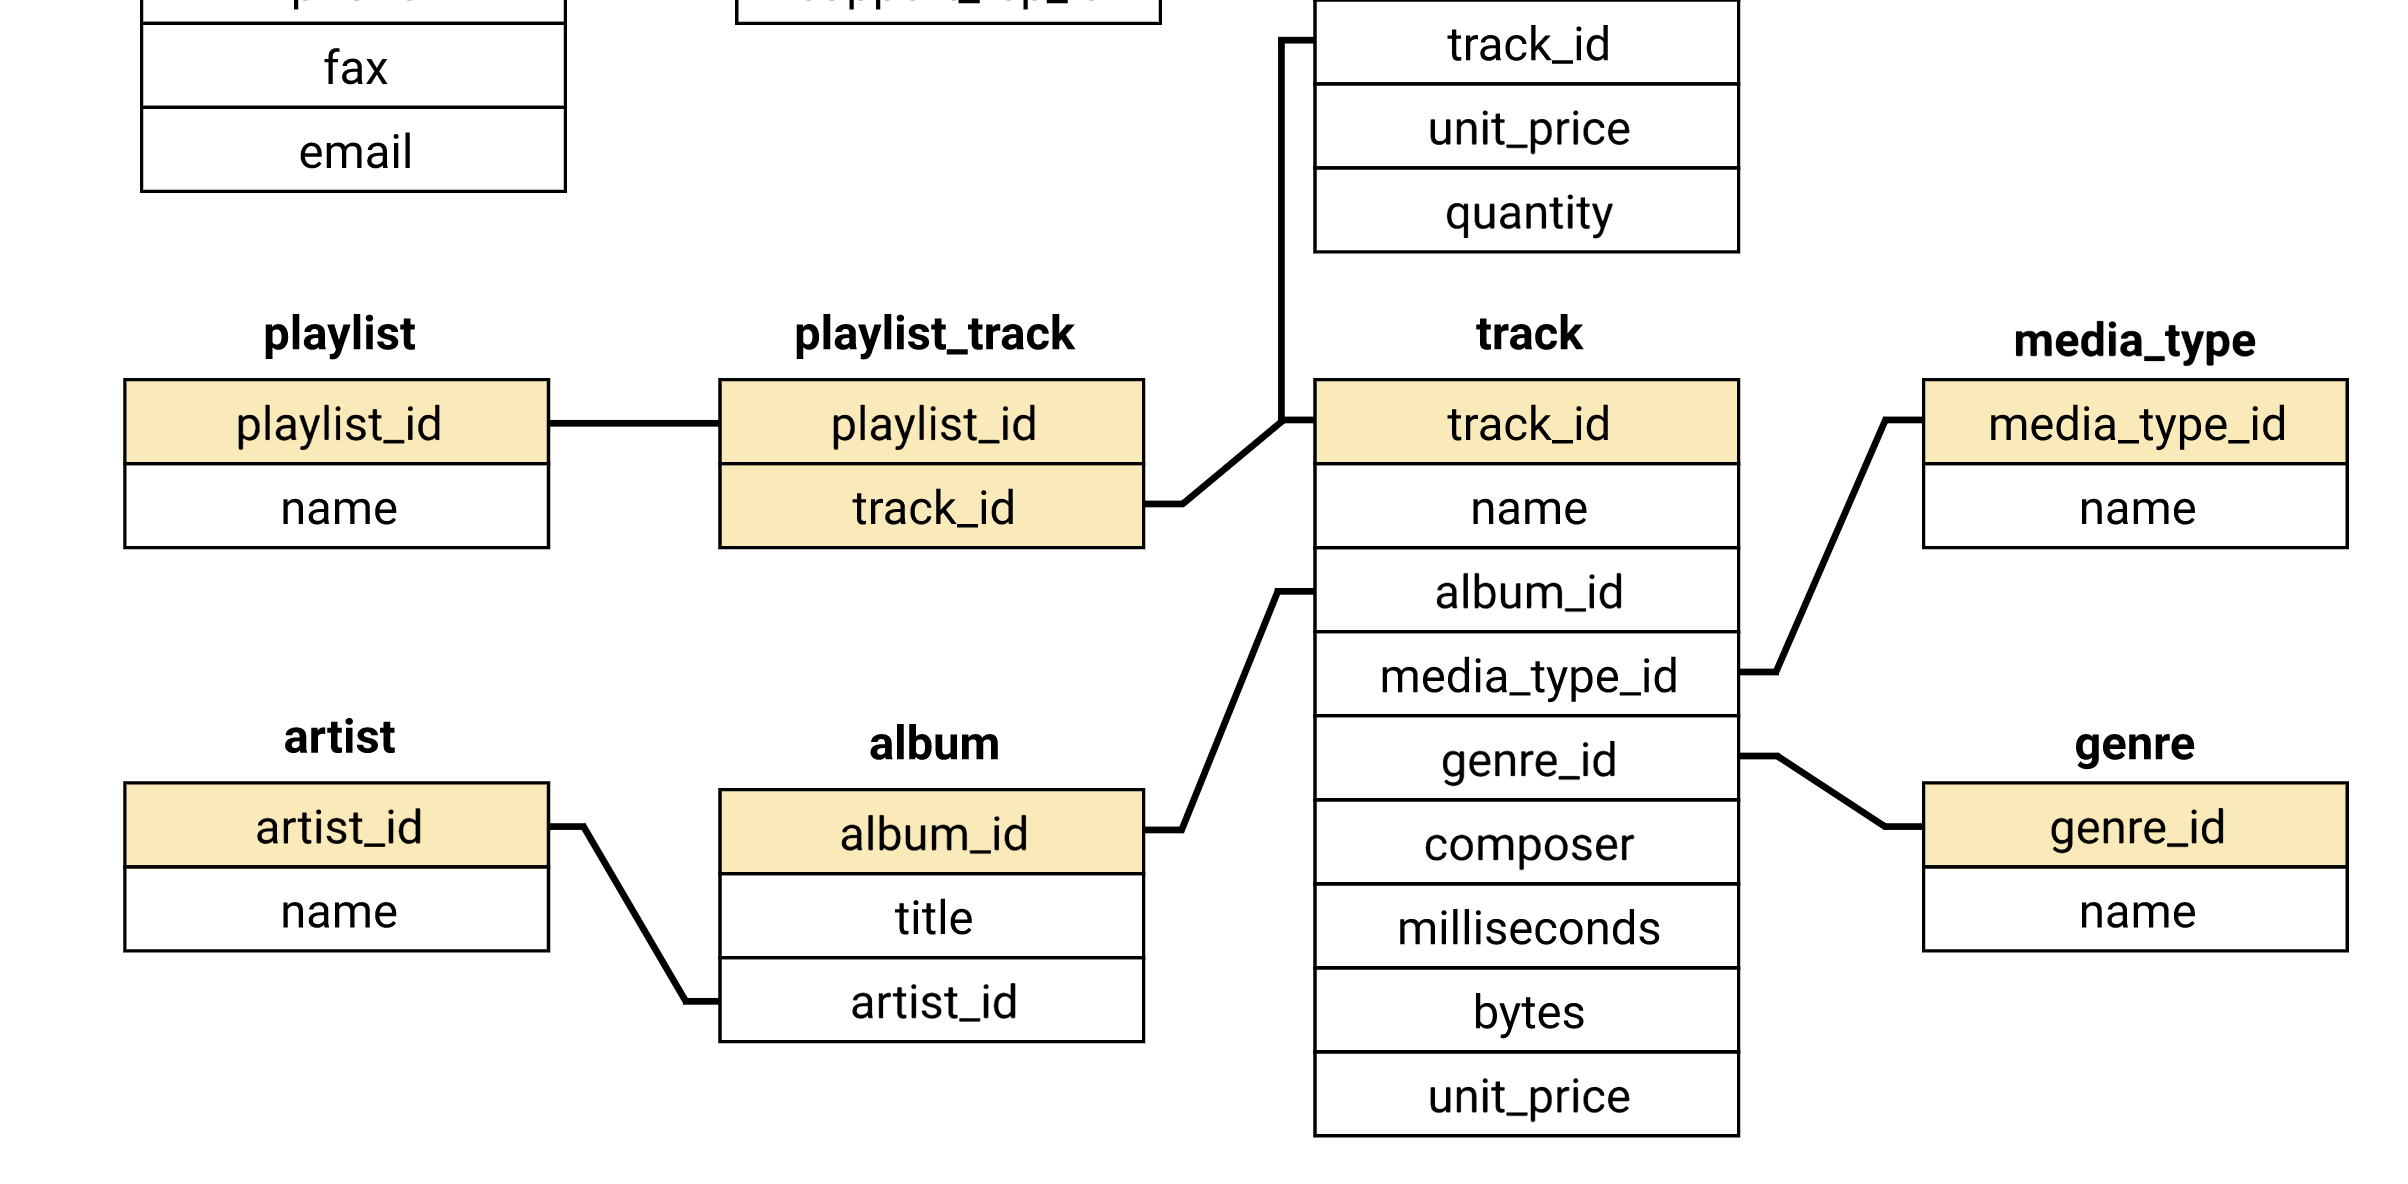

# Creating helper functions

In [3]:
%matplotlib inline
import sqlite3 as sl
import pandas as pd
import matplotlib as plt

db = "chinook.db"

def run_query(q):  
    with sl.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sl.connect(db) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
def show_tables():
    q = '''
    SELECT 
        name, 
        type 
    FROM sqlite_master 
    WHERE type IN ('table','view');
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Which three new albums should the store purchase?

The Chinook record store needs to select three albums from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name|Genre|
|---|---|
|Regal|Hip Pop|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|

*notes for codes: <br>1.在with subquery中，如果select某列，是为了在main query中求和或者求总数。<br>不然就选择全部。With语句的作用是为了压扁，去除不满足的行，所以可以select全部.<br>2. 注意alias不能用内置词 <br>3.求百分比是要把一个整数变成浮点.<br>4.括号内要用完整语句，不要用alias.*

In [4]:
genre_to_purchase = '''
WITH sold_USA AS 
    (
    SELECT 
        g.name genre,
        il.invoice_line_id invoiceline
    FROM track t
    INNER JOIN genre g ON t.genre_id = g.genre_id
    INNER JOIN invoice_line il ON t.track_id = il.track_id
    INNER JOIN invoice inv ON inv.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = inv.customer_id
    WHERE c.country = "USA"
    )         
SELECT 
    genre, 
    COUNT(invoiceline) genre_sold,
    CAST(COUNT(invoiceline) AS FLOAT)/(SELECT COUNT(*) FROM sold_USA) percent_sold
FROM sold_USA
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
   
run_query(genre_to_purchase)

,genre,genre_sold,percent_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Based on the sales of different genre records sold in USA, the 3 albulms we should purchase are:<br>
- Red Tone Punk 
- Meteor and the Girls Pop 
- Slim Jim Bites Blues.<br>

The total sales of the three genres are only 17% of the total sales. We should look for Rock albums which are 53% of the sales.

# How do the sales agents perform?

In [5]:
q='''
select * from employee
where title = "Sales Support Agent"
'''
run_query(q)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
1,4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
2,5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com


In [6]:
agent_sales = '''
WITH em_cus_inv AS
(SELECT * 
 FROM employee e
 LEFT JOIN customer c ON e.employee_id = c.support_rep_id
 LEFT JOIN invoice inv ON c.customer_id = inv.customer_id
 WHERE e.title = "Sales Support Agent"
)

SELECT 
    employee_id,
    first_name||" "||last_name employee_name,
    hire_date,
    SUM(total) total_sales
FROM em_cus_inv eci
GROUP BY 1
ORDER BY 4 DESC;
'''

run_query(agent_sales)

,employee_id,employee_name,hire_date,total_sales
0,3,Jane Peacock,2017-04-01 00:00:00,1731.51
1,4,Margaret Park,2017-05-03 00:00:00,1584.00
2,5,Steve Johnson,2017-10-17 00:00:00,1393.92


__The top sales agent has 20% more sales than the last sales agent, but the top sales agent was hired 6 months earlier. More experience could explain the sales difference. __

# How are sales in difference countries?

In [7]:
q = '''
select country, count(customer_id) from customer 
group by 1
order by 2 DESC
'''
run_query(q)

,country,count(customer_id)
0,USA,13
1,Canada,8
2,Brazil,5
3,France,5
4,Germany,4
5,United Kingdom,3
6,Czech Republic,2
7,India,2
8,Portugal,2
9,Argentina,1


__from above we can see that many countries only have one customer. We will group these countries together as "other" in the analysis below.__

*notes for codes：<br>
create view:提取有用的列，建立other国家的虚拟列<br>
把国家分成other和各国：先用case设立虚拟列，把country分成原名和other。<br>把other的部分排在最后：再读取带有此列的表，设立另一虚拟列:如other即为0。此列要用于order by，所以需要出现在select里，但最终表格不能有0，1，所以需要在main query的from中做好最终表，select时只需简单选择列名.<br>*

*在view里，如果加入aggregation的列，就要有group by, 又因为是同一段落，国家的列里有aggregate function,不能用在group by里，所以那些求和的列要在main query中出现。View里只负责添加带有other的虚拟列。*

In [9]:
customer_invoice = '''
CREATE VIEW c_inv AS
    SELECT 
        c.customer_id,
        country,
        invoice_id,
        total,
        CASE
            WHEN (SELECT COUNT(*) FROM customer WHERE country=c.country)=1
            THEN 'other'
            ELSE c.country
        END AS country_other
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id;
'''
run_command(customer_invoice)

In [10]:
country_customer_sales = '''
SELECT
    countries,
    total_customer,
    total_sales,
    customer_lifetime_value,
    average_ordervalue
FROM (
     SELECT
        country_other countries,
        COUNT(distinct customer_id) total_customer,
        SUM(total) total_sales,
        SUM(total)/COUNT(distinct customer_id) customer_lifetime_value,
        SUM(total)/COUNT(invoice_id) average_ordervalue,
        CASE
            WHEN country_other = 'other'
            THEN 1
            ELSE 0
         END AS sort
     FROM cus_inv ci
     GROUP BY 1
     ORDER BY sort, total_sales DESC
     )
'''
run_query(country_customer_sales)

,countries,total_customer,total_sales,customer_lifetime_value,average_ordervalue
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,other,15,1094.94,72.996000,7.448571


__From the above result we can see that North America is our major market. USA has the most number of customers and the top sales. Canada follows USA as the second position. The biggest customer in South America is Brazil while Frence and Germany take up of majority sales in Europe.__

# Should Chinook store change its purchasing strategy?
## Background
The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:
- purchase a whole album
- purchase a collection of one or more individual tracks.
The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

Should they change to the new stratrgy? In order to answer this, we need to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

## Algorithm

Based on the above requirements, the columns we need are invoice_id, track_id, and album_id. We need to find the fewest tables that have these columns<br>Table "invoice_line" and "track" meet the requirement. The column they share is "track_id". So our algorithm will start from here.<br>

We can get the album_id linked to the first track_id in each invoice. If the tracks under this album_id match all the tracks under this invoice, vice versa, we can conclude that this invoice has one full album with no seperate tracks from other albums. <br>

There will be 3 parts of codes:
1. a subquerry with common columns: invoice_id and track_id of the first track in each invoice.<br>
2. a subquerry with Case filter.<br>FROM each table, we need to SELECT track_id with different WHERE conditions: <br>
      In table "invoice_line", SELECT the tracks in this invoice, the invoice_id of this invoice should match the invoice_id of the first subquerry <br>
      In table "track", SELECT the tracks that their album_id match the album_id of the first track in the invoice.
3. the main query: FROM the inner join of the above two subquerries.

### Edge cases
- Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
In this case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.
The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In [22]:
strategy_change = '''
WITH 
    inv_first_track AS 
    (SELECT
        il.invoice_id,
        MIN(il.track_id) first_track
    FROM invoice_line il
    GROUP BY 1),

    album_purchase AS 
    (SELECT
        invoice_id,
        CASE
          WHEN(
               (
                SELECT t.track_id
                FROM track t  
                WHERE t.album_id = (SELECT t2.album_id FROM track t2 WHERE t2.track_id=ift.first_track)                
                EXCEPT               
                SELECT il2.track_id 
                FROM  invoice_line il2
                WHERE il2.invoice_id = ift.invoice_id   
               ) IS NULL              
              AND            
               (
                SELECT il2.track_id 
                FROM  invoice_line il2
                WHERE il2.invoice_id = ift.invoice_id 
                EXCEPT
                SELECT t.track_id
                FROM track t  
                WHERE t.album_id = (SELECT t2.album_id FROM track t2 WHERE t2.track_id=ift.first_track)               
               ) IS NULL
             )
          THEN "YES"
          ELSE "NO"
        END AS album_or_not
    FROM inv_first_track ift
    GROUP BY 1)
    
SELECT
    ap.album_or_not,  
    COUNT(ap.invoice_id) purchase_times, 
    CAST(COUNT(ap.invoice_id) AS FLOAT)/(SELECT COUNT(*) FROM invoice) percentage
FROM album_purchase ap
INNER JOIN inv_first_track ift ON ift.invoice_id = ap.invoice_id
GROUP by 1;
'''

run_query(strategy_change)

,album_or_not,purchase_times,percentage
0,NO,500,0.814332
1,YES,114,0.185668


## Conclusion

Of all the purchase invoices, 81.4% of the times that the customers chose from more than one albums within one order.
18.5% of the orders were placed as full albums.
If the company decides not to buy full albums, they might loose the 18.5% of the total cusotmer, which might cause more loss than the money saved by not purchasing full albums.
The suggestion is that the company should not change the strategy to not buying full albums.


*Further exploration:
Which artist is used in the most playlists?
How many tracks have been purchased vs not purchased?
Is the range of tracks in the store reflective of their sales popularity?
Do protected vs non-protected media types have an effect on popularity?*